This one doesn't quite work. It works a bit though.

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the MNIST model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.softmax(x, dim=1)
        return output

In [3]:
# Initialize the pre-trained model
model = Net()
model.load_state_dict(torch.load('../../data/models/mnist_cnn.pt', map_location=torch.device('cpu')))
model.eval();

In [4]:
# Example
label  = 4
#img_id = 9777
#img = Image.open(f"../../mnist_test_imgs/{label}/{img_id}.png")
img = Image.open("../../data/pictures/4.png")
preprocess = transforms.Compose([
   transforms.Resize(28),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

Predicted 4 with probability: 0.99985671043396.


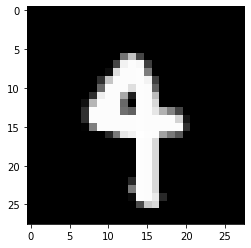

In [5]:
plt.imshow(img, cmap = "gray")
tensor = preprocess(img)[0].reshape(1,1,28,28)
prediction = model(tensor)
item = prediction.argmax().item()
prob = prediction.max().item()
print(f'Predicted {item} with probability: {prob}.')

In [6]:
min_prob = 1
adv1 = None
print("Pixel 1...")
for i in range(img.size[0]): # for every pixel:
    for j in range(img.size[1]):
        for pxl in [0,1]:
            img_cpy = img.copy()
            img_cpy.load()[i,j] = pxl
            prediction = model(preprocess(img_cpy)[0].reshape(1,1,28,28))
            prob = prediction[0].detach().numpy()
            if prob[label] < min_prob:
                min_prob = prob[label]
                adv1 = [i,j,pxl]
print("Done.")

if adv1 is None:
    print("Failed.")
else:
    min_prob = 1
    adv2 = None
    print("Pixel 2...")
    for i in range(img.size[0]): # for every pixel:
        for j in range(img.size[1]): 
            if not (i == adv1[0] and j == adv1[1]):
                for pxl in [0,1]:
                    img_cpy = img.copy()
                    img_cpy.load()[adv1[0],adv1[1]] = adv1[2]
                    img_cpy.load()[i,j] = pxl
                    prediction = model(preprocess(img_cpy)[0].reshape(1,1,28,28))
                    prob = prediction[0].detach().numpy()
                    if prob[label] < min_prob:
                        min_prob = prob[label]
                        adv2 = [i,j,pxl]
    print("Done.")

Pixel 1...
Done.
Pixel 2...
Done.


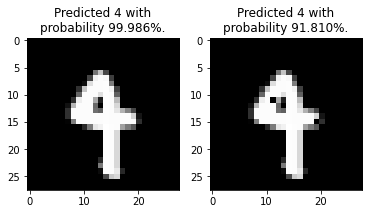

In [7]:
adv_img = img.copy()
adv_img.load()[adv1[0], adv1[1]] = adv1[2]
adv_img.load()[adv2[0], adv2[1]] = adv2[2]

# Predict original
img_tensor = preprocess(img)[0].reshape(1,1,28,28)
prediction_img = model(img_tensor)
item_img = prediction_img.argmax().item()
prob_img = prediction_img.max().item()

# Predict adversarial
adv_img_tensor = preprocess(adv_img)[0].reshape(1,1,28,28)
prediction_adv_img = model(adv_img_tensor)
item_adv_img = prediction_adv_img.argmax().item()
prob_adv_img = prediction_adv_img.max().item()

fig, axs = plt.subplots(1,2);
axs[0].imshow(img, cmap = "gray");
axs[0].set_title("Predicted %d with\nprobability %.3f%%." % (item_img, prob_img * 100));
axs[1].imshow(adv_img, cmap = "gray");
axs[1].set_title("Predicted %d with\nprobability %.3f%%." % (item_adv_img, prob_adv_img * 100));

